# LIBRARIES TO BE USED

In [38]:
# To import dataset and manage using Githube.com ( https://github.com/viniciusparede/house-prices-prediction-ppgia )
import os
import git

# Data Manipulation and Calculation
import pandas as pd
import numpy as np
import math
from scipy.stats import mode
from sklearn.neighbors import KNeighborsRegressor
from skrebate import ReliefF
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans


# Charts and visualization
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker

# LOAD DATA SET FROM GITHUB

In [39]:
# Function to load dataset from githun
def get_git_root(path) -> str:
    git_repo = git.Repo(path, search_parent_directories=True)
    git_root = git_repo.git.rev_parse("--show-toplevel")
    return git_root


git_dir = get_git_root(os.getcwd()) # Github folder where dataset is storaged.
data_dir = os.path.join(git_dir, "data") # Data folder

# Import dataset to a DataFrame
df_train = pd.read_csv(os.path.join(data_dir, "train.csv")) # [!] main dataset to be analyzed
df_test = pd.read_csv(os.path.join(data_dir, "test.csv"))

In [40]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [41]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# GROUP OF QUESTIONS #1:
# DATASET DESCRIPTION (DESCRIÇÃO DA BASE DE DADOS)

1) Indicar o nome da base:

House Prices ( https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/rules )


2) Que tipo de dado (ou problema) caracteriza esta base de dados, ou seja, o que se pretende extrair de conhecimento a partir dos dados lá disponíveis (classificação/regressão, agrupamento, associação, por exemplo):

Classificação/regressão e agrupamento


3) Indicar quem forneceu esta base, além da data da coleta dos dados (início e final), além de particularidades (por exemplo, a coleta foi interrompida durante um período de tempo e depois retomada):

O próprio site da Kaggle forneceu a base de dados como forma de competição. Mesmo analisando os metadados da base e o arquivo “data_description.txt”, não foi possível identificar a data de coleta dos dados e a data de criação da base de dados


4) Indicar se existem informações já publicadas sobre seu uso e, em caso positivo, onde foi publicado, por quem, o quê:

Sim, há publicações prévias e devido ao fato da base ser uma base de competição, existem vários notebooks já publicados, no próprio site do Kaggle ( https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/code?competitionId=5407&sortBy=scoreAscending )



5) Quantas classes existem e quais são elas, no caso de classificação, ou o nome e a faixa de valores da variável a ser prevista no caso de regressão:

Existem 81 classes/colunas/atributos no arquivo com diversos tipos de variáveis.  numéricas (sejam intervalos ou ratios) e categóricas (nominais ou ordinais). As faixas de valores e tipos de variáveis podem ser vistos no arquivo "data_description.txt".




# GROUP OF QUESTIONS #2:
# DATASET FEATURES (CARACTERÍSTICAS DA BASE DE DADOS)

There are 14 question in this group and each question will be in it own markdown field below.

1) Quantas instâncias existem?

Existe 1460 instâncias, conforme código abaixo.


2) Quantos atributos existem?

Existem 81 atributos/colunas, conforme código abaixo.

In [42]:
print(df_train.shape) #Check size of df_train

(1460, 81)


3) O tipo de cada atributo?

Vide na lista (Dtype) e no gráfico abaixo, sendo que "int64" e "float64" são variáveis numéricas e "objects" são variáveis categóricas.

In [43]:
df_train.info() #Check the df_train properties, including the type of each atribute/column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

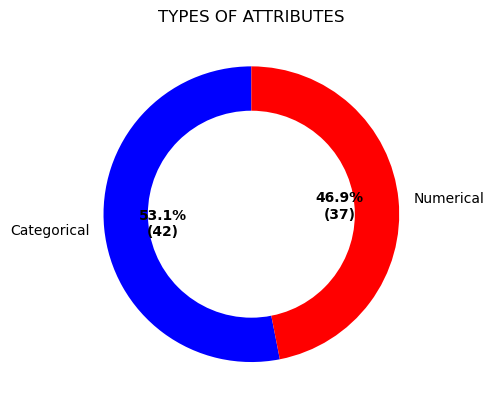

In [44]:
#ACCOUNTING THE TYPES OF ATTRIBUTES

dtypes_count = df_train.dtypes.replace({'float64': 'Numerical', 'int64': 'Numerical', 'object': 'Categorical'}).value_counts()
### Create a chart to show it
sizes = dtypes_count.values
labels = dtypes_count.index.astype(str)
colors = ['blue', 'red']

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sizes.sum())})', startangle=90)
plt.setp(autotexts, size=10, weight='bold')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
plt.title('TYPES OF ATTRIBUTES', loc='center')
plt.show()
### ENF OF Create a chart to show it



4) Há informações sobre ruído? Em caso positivo, quais?

Não existem ruídos propriamente ditos, pois esta base não se trata de uma série temporal.
Foram identificados colunas onde um valor NULL ou n/a preenchido não significa vazio e sim que tal atributo pode ser zero ou não existe na casa. Exemplo: PoolQC (Qualidade da Piscina), onde um valor NULL em sua célula significa que não há piscina naquela casa:

        PoolQC: Pool quality
                
            Ex	Excellent
            Gd	Good
            TA	Average/Typical
            Fa	Fair
            NA	No Pool


Diante das variáveis e análises univariadas e multivariadas que fizemos, não identificamos ruídos nos dados. Foram identificados outliers muito fora dos quartis, porém foi dado o benefício da dúvida que ali não se trata de um ruído e sim uma variabilidade de mercado, que segundo Richard H. Thaler, comporta-se de forma irracional em amplos âmbitos de negociação e avaliação.


In [45]:
# Calcular a porcentagem de valores ausentes em cada coluna com valores ausentes maiores que 0
missing_data = df_train.isnull().sum()[df_train.isnull().sum() > 0]
missing_data_percentage = missing_data / len(df_train) * 100

# Combinar as informações em um dataframe
df_train_missing_values = pd.concat(
    [missing_data, missing_data_percentage], axis=1, keys=["Total", "Percentage"]
)

# Ordenar os valores pela porcentagem de valores ausentes em ordem decrescente
df_train_missing_values = df_train_missing_values.sort_values(by="Percentage", ascending=False)

df_train_missing_values


### Columns where N/A means "has no this attribute", not missing value. They will be filled with "none":
#Alley
#BsmtQual
#BsmtCond
# BsmtExposure
# BsmtFinType1
# BsmtFinType2
# FireplaceQu
# GarageType
# GarageFinish
# GarageQual
# GarageCond
# PoolQC
# Fence
# MiscFeature


### Columns below does not have N/A as "has no attribute" and will be filled with "not answered", instead of missing value:
# MasVnrType: Masonry veneer type

#        BrkCmn	Brick Common
#        BrkFace	Brick Face
#        CBlock	Cinder Block
#        None	None
#        Stone	Stone



# Electrical: Electrical system

#        SBrkr	Standard Circuit Breakers & Romex
#        FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
#        FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
#        FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
#        Mix	Mixed




### The others that will be filled with zero:

#LotFrontage: Linear feet of street connected to property
# MasVnrArea: Masonry veneer area in square feet
# GarageYrBlt: Year garage was built



,Total,Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945


In [46]:
#FILL MISSING VALUES AND CHECK AGAIN

# Lista de colunas que precisam ser preenchidas com "NA"
cols_to_fillna = [
    "PoolQC",
    "MiscFeature",
    "Alley",
    "Fence",
    "FireplaceQu",
    "GarageType",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "BsmtExposure",
    "BsmtFinType2",
    "BsmtFinType1",
    "BsmtCond",
    "BsmtQual",
]

df_train_filled = df_train.copy()

# Usando uma compreensão de lista para preencher os valores ausentes com "NA" em cada coluna
for col in cols_to_fillna:
    df_train_filled[col].fillna("NA", inplace=True)

# Preenchendo os valores ausentes no atributo "LotFrontage" com o valor padrão "0"
df_train_filled["LotFrontage"].fillna(0, inplace=True)

# Preenchendo os valores ausentes no atributo "GarageYrBlt" com o valor padrão "0"
df_train_filled["GarageYrBlt"].fillna(0, inplace=True)

# Excluindo as instâncias com valores ausentes (conjunto pequeno em relação ao tamanho do conjunto de dados)
cols_to_dropna = ["MasVnrType", "MasVnrArea", "Electrical"]
df_train_filled.dropna(subset=cols_to_dropna, inplace=True)
#df_train_filled.drop(columns=["Id"], inplace=True)

5) Há indicação de outliers?

Diante das variáveis e análises univariadas e multivariadas que fizemos, não identificamos ruídos nos dados. Foram identificados outliers muito fora dos quartis, porém foi dado o benefício da dúvida que ali não se trata de um ruído e sim uma variabilidade de mercado, que segundo Richard H. Thaler, comporta-se de forma irracional em amplos âmbitos de negociação e avaliação.

Sim. Dado a dimensão dessa base de dados seria estranho se algum dos 80 atributos não apresentassem outliers. Abaixo segue um exemplo onde o Preço de Vendas (SalePrice) é confrontrado, em boxplot, com outras variáveis como Vizinhança (Neighborhoo), Condição Geral do Imóvel (OverallCond) e Qualidade Geral do imóvel (OverallQual).

In [47]:
#CHECK OUTLIERS

#First, split the columns in two groups: Categorical and Numerical
numericos = list(df_train.select_dtypes(include=['int64', 'float64']).columns)
categoricos = list(df_train.select_dtypes(include=['object']).columns)
print('### THE NUMERICAL COLUMNS ARE:')
print(numericos)
print('\n### THE CATEGORICAL COLUMNS ARE:')
print(categoricos)
print(f'\nTOTAL COLUMNS ANALYZED ARE: {len(numericos) + len(categoricos)}')

### THE NUMERICAL COLUMNS ARE:
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

### THE CATEGORICAL COLUMNS ARE:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',

In [48]:
#Second, use LabelEncoder() to analyze categorical columns as numerical

#from sklearn.preprocessing import LabelEncoder #import library LabelEncoder
df_train_filled_encoded = pd.DataFrame() #Create a new dataframe to store the label encoded data
mapa_de_legendas = {} #Create a dictionary to store the mapping of categorical values to numerical values

# Encode the categorical variables using LabelEncoder and store the mapping
label_encoder = LabelEncoder()
for col in categoricos: #ADD categorical columns, encoded, to new dataframe df_train_filled_encoded
    encoded_values = label_encoder.fit_transform(df_train_filled[col])
    df_train_filled_encoded[col] = encoded_values
    mapa_de_legendas[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# END OF Encode the categorical variables using LabelEncoder and store the mapping

df_train_filled_encoded[numericos] = df_train_filled[numericos] #Add the numeric columns to df_train_filled_encoded

df_train_filled_encoded


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,3,1,1,3,3,0,4,0,5,2,...,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0
1,3,1,1,3,3,0,2,0,24,1,...,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0
2,3,1,1,0,3,0,4,0,5,2,...,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0
3,3,1,1,0,3,0,0,0,6,2,...,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0
4,3,1,1,0,3,0,2,0,15,2,...,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,3,1,1,3,3,0,4,0,8,2,...,261.0,39.0,0.0,0.0,0.0,0.0,0.0,4.0,2010.0,157900.0
1447,3,1,1,3,3,0,4,0,14,2,...,0.0,65.0,0.0,0.0,0.0,0.0,0.0,12.0,2007.0,240000.0
1448,3,1,1,3,3,0,4,0,6,2,...,168.0,24.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,112000.0
1449,3,1,1,3,3,0,4,0,12,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2006.0,92000.0


In [49]:
# Print the label mapping dictionary
print('\n\n### LABEL MAP OF CATEGORICAL COLUMNS ENCODED')
for col, mapping in mapa_de_legendas.items():
    print(f"\nLabel Mapping for column '{col}':")
    for category, encoded_value in mapping.items():
        print(f"{category}: {encoded_value}")
print('### END OF LABEL MAP OF CATEGORICAL COLUMNS ENCODED\n\n')



### LABEL MAP OF CATEGORICAL COLUMNS ENCODED

Label Mapping for column 'MSZoning':
C (all): 0
FV: 1
RH: 2
RL: 3
RM: 4

Label Mapping for column 'Street':
Grvl: 0
Pave: 1

Label Mapping for column 'Alley':
Grvl: 0
NA: 1
Pave: 2

Label Mapping for column 'LotShape':
IR1: 0
IR2: 1
IR3: 2
Reg: 3

Label Mapping for column 'LandContour':
Bnk: 0
HLS: 1
Low: 2
Lvl: 3

Label Mapping for column 'Utilities':
AllPub: 0
NoSeWa: 1

Label Mapping for column 'LotConfig':
Corner: 0
CulDSac: 1
FR2: 2
FR3: 3
Inside: 4

Label Mapping for column 'LandSlope':
Gtl: 0
Mod: 1
Sev: 2

Label Mapping for column 'Neighborhood':
Blmngtn: 0
Blueste: 1
BrDale: 2
BrkSide: 3
ClearCr: 4
CollgCr: 5
Crawfor: 6
Edwards: 7
Gilbert: 8
IDOTRR: 9
MeadowV: 10
Mitchel: 11
NAmes: 12
NPkVill: 13
NWAmes: 14
NoRidge: 15
NridgHt: 16
OldTown: 17
SWISU: 18
Sawyer: 19
SawyerW: 20
Somerst: 21
StoneBr: 22
Timber: 23
Veenker: 24

Label Mapping for column 'Condition1':
Artery: 0
Feedr: 1
Norm: 2
PosA: 3
PosN: 4
RRAe: 5
RRAn: 6
RRNe: 7
RRN

In [62]:
#CALCULATE OUTLIERS

# Calculate IQR per column
q1 = df_train_filled_encoded.quantile(0.25)
q3 = df_train_filled_encoded.quantile(0.75)
iqr = q3 - q1
# END OF Calculate IQR per column

# According the IQ Method, outliers are those values above or below of 1.5*IQR
lower_threshold = q1 - 1.5 * iqr
upper_threshold = q3 + 1.5 * iqr
# According the IQ Method, outliers are those values above or below of 1.5*IQR

# Identifica as colunas com outliers
outlier_columns = df_train_filled_encoded.columns[(df_train_filled_encoded > upper_threshold).any()]
outlier_columns = df_train_filled_encoded.columns[(df_train_filled_encoded < lower_threshold).any()]
outlier_column_names = outlier_columns.tolist()

# Imprime a lista de colunas com outliers
print('### CATEGORICAL COLUMNS WITH OUTLIERS VALUES:')
outlier_categorical_columns = [item for item in categoricos if item in outlier_column_names]
print(outlier_categorical_columns)
print(f'TOTAL NUMERICAL COLUMNS WITH OUTLIERS: {len(outlier_categorical_columns)} of {len(categoricos)}')
print('\n### NUMERICAL COLUMNS WITH OUTLIERS VALUES:')
outlier_numerical_columns = [item for item in numericos if item in outlier_column_names]
print(outlier_numerical_columns)
print(f'TOTAL NUMERICAL COLUMNS WITH OUTLIERS: {len(outlier_numerical_columns)} of {len(numericos)}')
print(f'\n\nTOTAL COLUMNS WITH OUTLIERS VALUES: {len(outlier_column_names)} of {len(df_train.columns)} ({round(len(outlier_column_names)/len(df_train.columns)*100,1)}%)')
print('#############')
print(outlier_numerical_columns)



### CATEGORICAL COLUMNS WITH OUTLIERS VALUES:
['MSZoning', 'Street', 'Alley', 'LandContour', 'Condition1', 'Condition2', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
TOTAL NUMERICAL COLUMNS WITH OUTLIERS: 28 of 43

### NUMERICAL COLUMNS WITH OUTLIERS VALUES:
['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'TotalBsmtSF', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageYrBlt']
TOTAL NUMERICAL COLUMNS WITH OUTLIERS: 8 of 38


TOTAL COLUMNS WITH OUTLIERS VALUES: 36 of 81 (44.4%)
#############
['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'TotalBsmtSF', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageYrBlt']


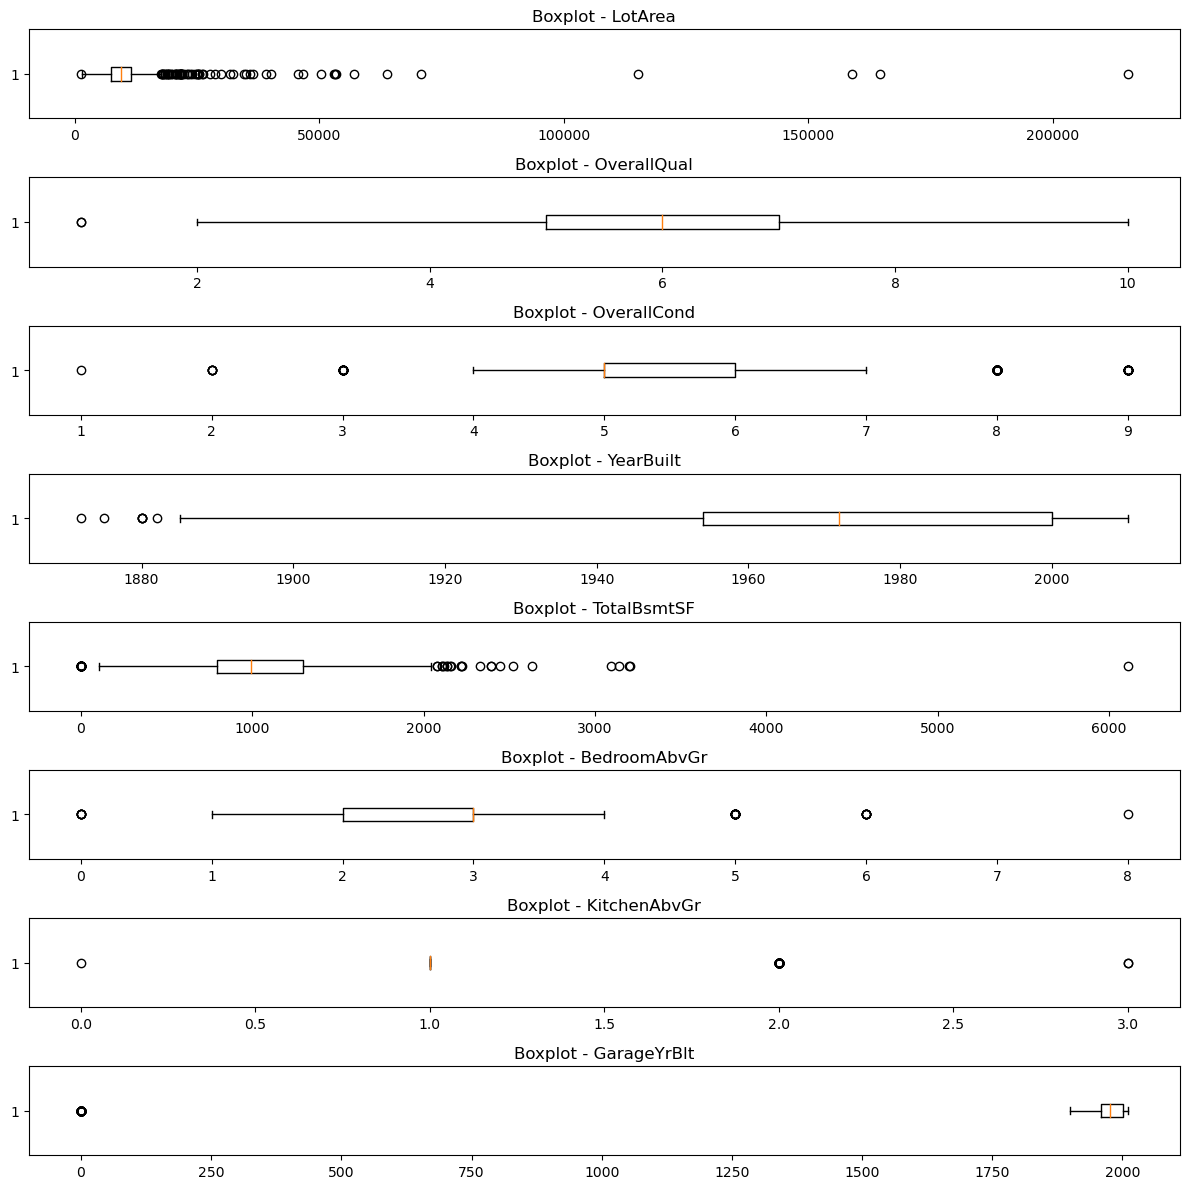

In [63]:
#PLOT BOXPLOT CHART FOR NUMERICAL COLUMNS WITH IDENFIED OUTLIERS VALUES

fig, axs = plt.subplots(len(outlier_numerical_columns), figsize=(12, 12))

for i, column in enumerate(outlier_numerical_columns):
    axs[i].boxplot(df_train_filled[column], vert=False)
    axs[i].set_title(f'Boxplot - {column}')

plt.tight_layout()
plt.show()



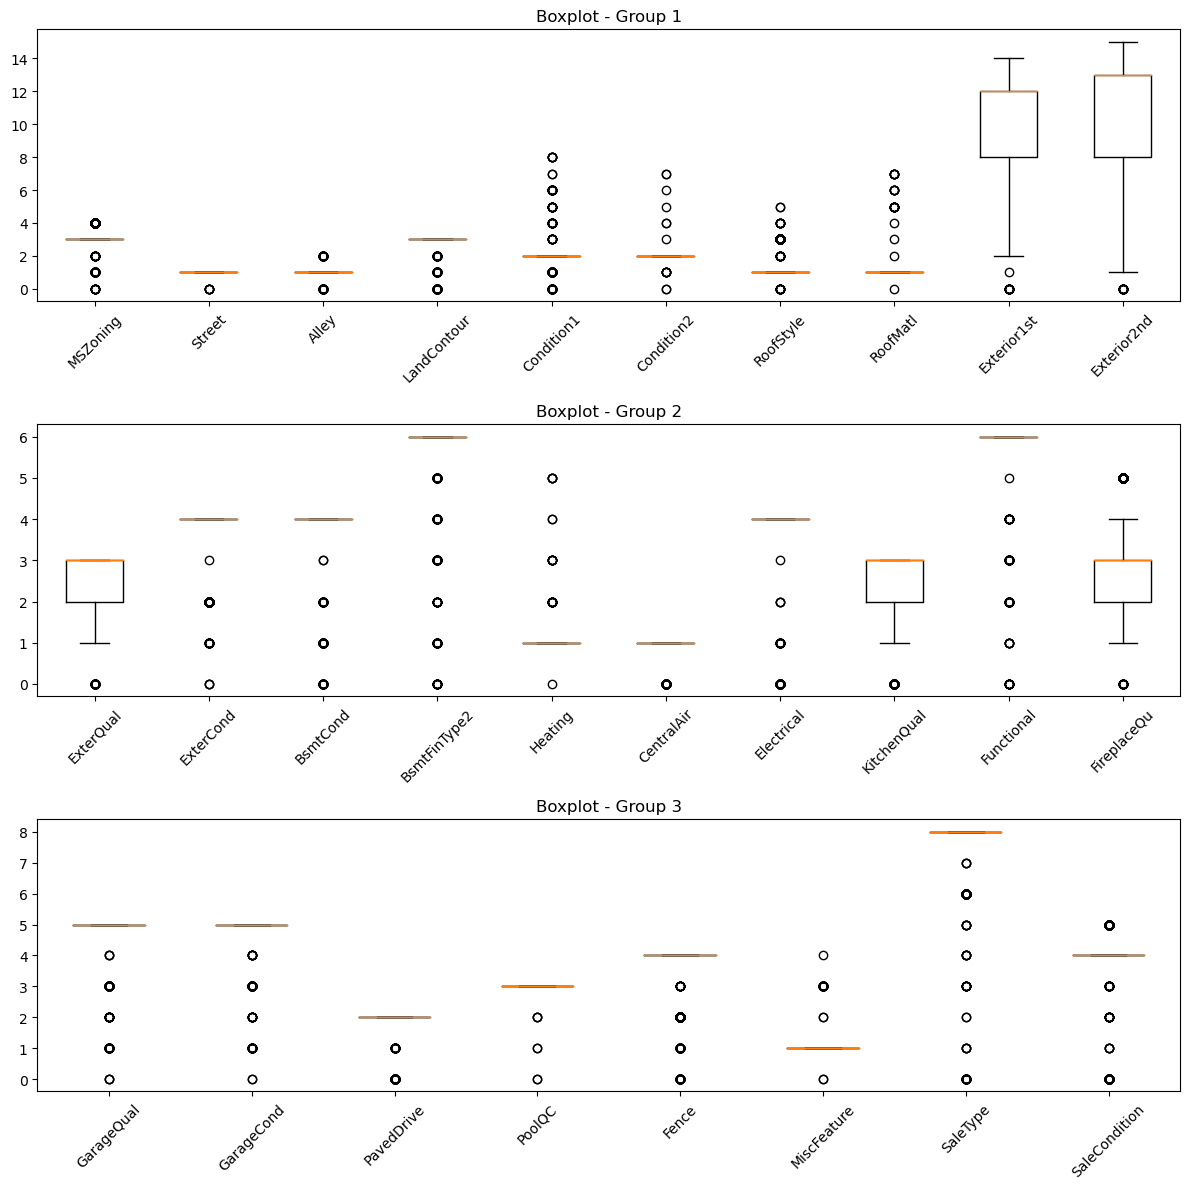

In [52]:
#PLOT BOXPLOT CHART FOR CATEGORICAL COLUMNS WITH IDENFIED OUTLIERS VALUES

num_plots = math.ceil(len(outlier_categorical_columns) / 10)

fig, axs = plt.subplots(num_plots, figsize=(12, 12))

for i in range(num_plots):
    start = i * 10
    end = min((i + 1) * 10, len(outlier_categorical_columns))
    columns_subset = outlier_categorical_columns[start:end]

    if num_plots > 1:
        axs_i = axs[i]
    else:
        axs_i = axs

    axs_i.boxplot(df_train_filled_encoded[columns_subset])
    axs_i.set_xticklabels(columns_subset, rotation=45)
    axs_i.set_title(f'Boxplot - Group {i + 1}')

plt.tight_layout()
plt.show()




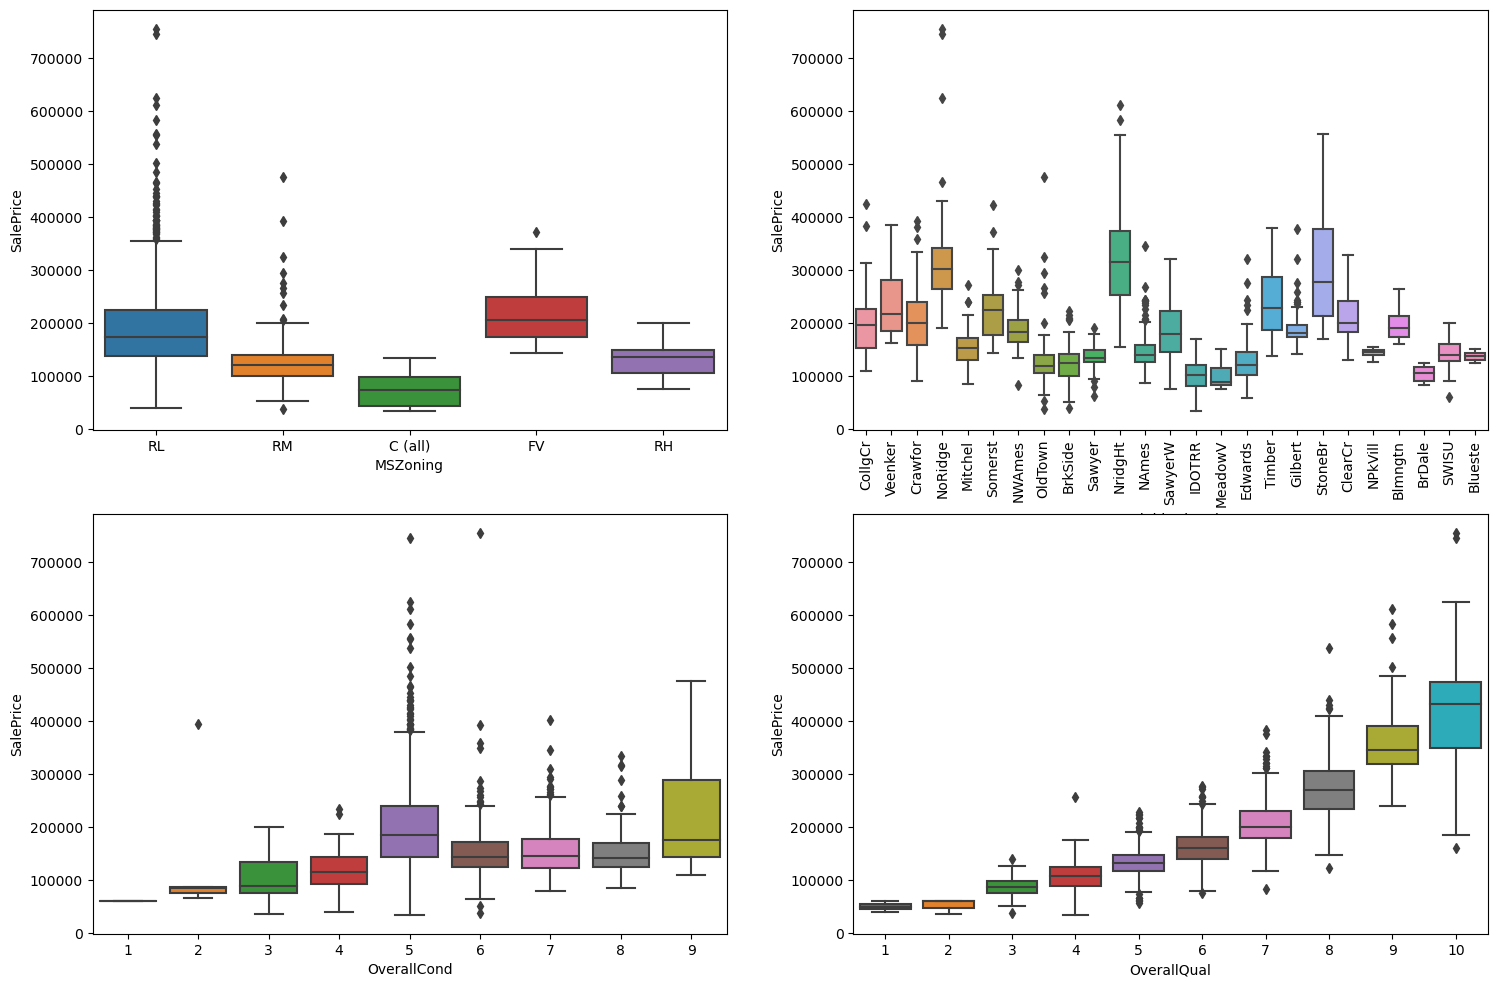

In [53]:
#Analyzing SalePrice columns with others


fig = plt.figure(figsize=(18, 12))

# Chart 1
fig.add_subplot(221)
#sns.countplot(df_train['MSZoning'])
sns.boxplot(x='MSZoning', y='SalePrice', data=df_train)
                 
# Chart 2
fig.add_subplot(222)
#sns.boxplot(x='MSZoning', y='SalePrice', data=df_train)
ax222=sns.boxplot(x='Neighborhood', y='SalePrice', data=df_train)

# Chart 3
fig.add_subplot(223)
#sns.boxplot(x='Neighborhood', y='SalePrice', data=df_train)
sns.boxplot(x='OverallCond', y='SalePrice', data=df_train)

# Chart 4
fig.add_subplot(224)
#sns.violinplot(x = 'OverallQual', y = 'SalePrice', data=df_train, palette='Set3', bw=.2, cut=1, split=True, linewidth=1)
sns.boxplot(x='OverallQual', y='SalePrice', data=df_train)

## Rotate ax222 by 90 degrees
ax222.tick_params(axis='x', labelrotation=90)

6) Existem dados faltantes?

Sim. Este item foi respodido na questão 4.

Quatro atributos (colunas) chamam a atenção por ter mais de 80% de dados faltantes (vide destaque em laranja na imagem acima).

In [54]:
#JUST TO SUMMARIZY THE QUANTITY OF MISSING VALUES PER COLUMNS

null_sum = df_train.isnull().sum()
null_cols = null_sum[null_sum>0]
num_instances = len(df_train)
for col_name, col_sum in null_cols.items():
    percent_missing = round((col_sum/num_instances)*100,2)
    print(f"{col_name}: {col_sum} ({percent_missing}%)")

LotFrontage: 259 (17.74%)
Alley: 1369 (93.77%)
MasVnrType: 8 (0.55%)
MasVnrArea: 8 (0.55%)
BsmtQual: 37 (2.53%)
BsmtCond: 37 (2.53%)
BsmtExposure: 38 (2.6%)
BsmtFinType1: 37 (2.53%)
BsmtFinType2: 38 (2.6%)
Electrical: 1 (0.07%)
FireplaceQu: 690 (47.26%)
GarageType: 81 (5.55%)
GarageYrBlt: 81 (5.55%)
GarageFinish: 81 (5.55%)
GarageQual: 81 (5.55%)
GarageCond: 81 (5.55%)
PoolQC: 1453 (99.52%)
Fence: 1179 (80.75%)
MiscFeature: 1406 (96.3%)


7) Em existindo dados faltantes, crie duas novas bases a partir da original, em que não existam dados faltantes usando dois métodos diferentes.

A primeira base já foi criado anteriormente respondendo a questão 4. Chama-se "df_train_filled", onde foi analisado que entre os atributos que possuiam dados faltantes ou N/A alguns poderiam ser substituido por zero, outros por "none" e outros por "not answered". Possibilitando uma tratativa melhor dos dados.

O segundo método é um método simples de exclusão das instâncias que possui alguma variável N/A. O resultado disso é zerar por completo as instâncias da base nova (df_train_na)

In [55]:
df_train_na = df_train.dropna()

df_train_na.info()
df_train_na

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             0 non-null      int64  
 1   MSSubClass     0 non-null      int64  
 2   MSZoning       0 non-null      object 
 3   LotFrontage    0 non-null      float64
 4   LotArea        0 non-null      int64  
 5   Street         0 non-null      object 
 6   Alley          0 non-null      object 
 7   LotShape       0 non-null      object 
 8   LandContour    0 non-null      object 
 9   Utilities      0 non-null      object 
 10  LotConfig      0 non-null      object 
 11  LandSlope      0 non-null      object 
 12  Neighborhood   0 non-null      object 
 13  Condition1     0 non-null      object 
 14  Condition2     0 non-null      object 
 15  BldgType       0 non-null      object 
 16  HouseStyle     0 non-null      object 
 17  OverallQual    0 non-null      int64  
 18  OverallCond    0 non-n

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


8) É possível agregar dados na base? Quais?

Sim, é possível, porém a base de dados já possui vários atributos, tornando a adição desnecessário para a predição do SalePriec.

Uma opção de adição de dados seria o de nível de criminalidade nos bairros das casas ou até mesmo o preechimento dos dados faltantes como foi feito.

9) Qual a proporção entre as clases?

Resposta no gráfico abaixo

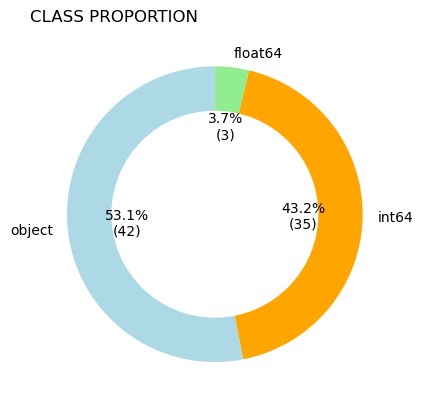

In [56]:
dtypes_count = df_train.dtypes.value_counts()
sizes = dtypes_count.values
labels = dtypes_count.index.astype(str)
colors = ['lightblue', 'orange', 'lightgreen']

#CHART
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sizes.sum())})', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
plt.title('CLASS PROPORTION', loc='left')
plt.show()

10) É necessário dimuir a dimensionalidade? Porquê?

Sim, faz-se necessário essa redução ainda mais que algumas variáveis possui pouca correlação com o target do trabalho que é o SalePrice (preço do imóvel). E como visto, algumas colunas?atributos, possuem mais de 90% de dados faltantes, sendo desnecessário ter essas colunas para nossas análises.

11) Apresente uma nova base com seleção de atributos usando o algoritmo Relief.

Vide códigos abaixo cujo produto é df_train_relief

In [57]:
# RELIEFF METHOD APPLIED

# Separate target column from the others
X = df_train_filled_encoded.drop("SalePrice", axis=1).drop("Id", axis=1) #Using df_train_filled_encoded the categorical columns are already converted to numerical
y = df_train_filled_encoded['SalePrice'].copy()
# END OF Separate target column from the others

#ReliefF
relief = ReliefF(n_neighbors=10) # https://epistasislab.github.io/scikit-rebate/using/
relief.fit(X.values, y.values)
feature_scores = relief.feature_importances_ #Extract the weights calculated by ReliefF

# Select the best columns that affect SalePrice
selected_features = X.columns[relief.top_features_] #????????????? Por algum motibo ele não está filtrando as 20 melhores, conforme especificado em n_features_to_select
X_selected = X[selected_features] #????????? Alternativa feita abaixo para filtrar os 20 atributos com maior influencia na variável alvo
print("Atributos selecionados:")
print(selected_features)
print("\nOrdem de importância dos atributos:")
relief_result = sorted(zip(selected_features, feature_scores), key=lambda x: x[1], reverse=True)
print(relief_result)
# END OF Select the best columns that affect SalePrice

c:\Users\tavar\anaconda3\lib\site-packages\skrebate\relieff.py:360: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(dist_array)


Atributos selecionados:
Index(['YrSold', 'MoSold', 'OverallQual', 'BsmtFinType1', 'Neighborhood',
       'OverallCond', 'LotFrontage', 'BsmtUnfSF', 'WoodDeckSF', 'FireplaceQu',
       'BedroomAbvGr', 'Exterior2nd', 'HouseStyle', 'BsmtFinSF1',
       'YearRemodAdd', 'HeatingQC', 'Exterior1st', 'TotRmsAbvGrd',
       'BsmtExposure', 'OpenPorchSF', 'LotConfig', 'Fireplaces',
       'GarageFinish', '1stFlrSF', 'GarageArea', 'MasVnrType', '2ndFlrSF',
       'LotShape', 'MasVnrArea', 'GarageCars', 'MSSubClass', 'BsmtFullBath',
       'YearBuilt', 'TotalBsmtSF', 'Fence', 'GarageType', 'GrLivArea',
       'KitchenQual', 'HalfBath', 'BsmtQual', 'RoofStyle', 'EnclosedPorch',
       'Foundation', 'SaleCondition', 'FullBath', 'Condition1', 'MSZoning',
       'BsmtFinType2', 'BldgType', 'ExterQual', 'BsmtFinSF2', 'ExterCond',
       'ScreenPorch', 'LandContour', 'SaleType', 'Electrical', 'BsmtCond',
       'PavedDrive', 'Functional', 'LotArea', 'GarageQual', 'BsmtHalfBath',
       'Alley', 'GarageC

In [58]:
#Alternativa to create a new dataframe with the first 20% of best atributes (columns) that affect target atribute.
df_train_relief = pd.DataFrame
top_relief_result = [item[0] for item in relief_result[:int(len(relief_result) * 0.2)]] #Select the first 20% (0.2)
df_train_relief = df_train_filled_encoded[top_relief_result].copy()
df_train_relief = df_train_relief.join(df_train["SalePrice"])
df_train_relief

,Utilities,Street,MSZoning,GarageArea,WoodDeckSF,BsmtFinType2,FullBath,LandContour,LowQualFinSF,YearBuilt,GarageCond,Exterior1st,HouseStyle,ExterCond,ExterQual,SalePrice
0,0,1,3,548.0,0.0,6,2.0,3,0.0,2003.0,5,12,5,4,2,208500
1,0,1,3,460.0,298.0,6,2.0,3,0.0,1976.0,5,8,2,4,3,181500
2,0,1,3,608.0,0.0,6,2.0,3,0.0,2001.0,5,12,5,4,2,223500
3,0,1,3,642.0,0.0,6,1.0,3,0.0,1915.0,5,13,5,4,3,140000
4,0,1,3,836.0,192.0,6,2.0,3,0.0,2000.0,5,12,5,4,2,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,0,1,3,312.0,261.0,6,1.0,3,0.0,1962.0,5,12,5,4,3,157900
1447,0,1,3,556.0,0.0,5,2.0,3,0.0,1995.0,5,9,2,4,3,240000
1448,0,1,3,384.0,168.0,6,1.0,3,0.0,1910.0,5,5,5,2,0,112000
1449,0,1,3,0.0,0.0,5,1.0,3,0.0,1970.0,5,8,2,4,3,92000


12) Apresente uma nova base com variáveis discretizadas por dois métodos diferentes;

Os dois métodos será aplicados a base df_train_relief.

Os métodos escolhidos foram o Binning (Discretização por Intervalos) e K-Mean.

A primeira base modificada chama-se df_train_relief_binning e a segunda df_train_relief_kmean.

Ambas oriundas de df_train_filled_encoded.

In [59]:
#BINNING METHOD TO DISCRETIZER
#from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

df_train_relief_binning = df_train_relief.drop('SalePrice', axis=1)  # Remove a coluna "SalePrice" do dataframe

for column in df_train_relief_binning.columns:
    if pd.api.types.is_numeric_dtype(df_train_relief_binning[column]):
        column_values = df_train_relief_binning[column].values.reshape(-1, 1)
        column_binned = discretizer.fit_transform(column_values)
        df_train_relief_binning[column] = column_binned.flatten()

df_train_relief_binning['SalePrice'] = df_train['SalePrice']

df_train_relief_binning



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
import matplotlib.pyplot as plt
import re

df_train_relief_kmean = df_train_relief.copy()

kmeans = KMeans(n_clusters=5, random_state=42)

for column in df_train_relief.columns:
    if pd.api.types.is_numeric_dtype(df_train_relief[column]):
        column_values = df_train_relief[column].values.reshape(-1, 1)
        discretized_values = kmeans.fit_transform(column_values)
        
        for i in range(discretized_values.shape[1]):
            new_column_name = f"{column}_bin_{i+1}"
            df_train_relief_kmean[new_column_name] = discretized_values[:, i]


df_train_relief_kmean


In [ ]:
discretized_columns = [column for column in df_train_relief_kmean.columns if column.endswith('_bin')]

# Plotar histograma para cada coluna
for column in discretized_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df_train_relief_kmean[column], bins=10, edgecolor='k')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.show()

In [ ]:

# Stats of df_relief
stats_relief = df_train_relief.describe().transpose()
stats_relief.rename(columns=lambda x: f"relief_{x}", inplace=True)

# Stats of df_train_relief_binning
stats_binning = df_train_relief_binning.describe().transpose()
stats_binning.rename(columns=lambda x: f"binning_{x}", inplace=True)

# Stats of df_train_relief_kmean
stats_kmean = df_train_relief_kmean.describe().transpose()
stats_kmean.rename(columns=lambda x: f"kmean_{x}", inplace=True)

# # Comparison between all
# stats_comparison = pd.concat([stats_relief, stats_binning, stats_kmean], axis=1)
# stats_comparison


In [ ]:
stats_binning

In [ ]:
stats_kmean

In [ ]:
stats_relief

14) Indique os gráficos de dispersão dos atributos.

Resposta no código abaixo.

In [ ]:
#SCATTERPLOT OF DF_TRAIN_RELIEF
sns.set_palette("PuOr")
sns.set_style("whitegrid")

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(12, 15))

for i, column in enumerate(df_train_relief.columns):
    if column == "SalePrice":
        continue
    ax = axs[i // 3, i % 3]
    sns.scatterplot(x=column, y="SalePrice", data=df_train_relief, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel("SalePrice")

plt.tight_layout()
plt.show()
